In [ ]:
!pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7849999838779980990
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14572174331698361200
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import tensorflow as tf


In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



#Датасет


в качестве набора данных был выбран датасет PTB-XL, по тем сооброжениям, что это самый популярный датасет, по нему в целом много информации и есть документация.
Также

Далее код для получения даных


In [ ]:
import zipfile
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
z_file = '/content/drive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip'

In [ ]:
z = zipfile.ZipFile(z_file, 'r')
z.extractall()

In [ ]:
!pip install wfdb==4.0.0
import wfdb

In [ ]:
import os
import ast


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras

sns.set_style('darkgrid')

Создаем датафрейм с помощью библиотеки pandas


In [ ]:
PATH_TO_DATA = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'

ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')

#Предобработка

Делаем приведение даных к нужным типам

Создаем еще один датафрейм, в которм хранятся диагнозы SCP_df

In [ ]:
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x: ast.literal_eval(x))
ECG_df.patient_id = ECG_df.patient_id.astype(int)
ECG_df.nurse = ECG_df.nurse.astype('Int64')
ECG_df.site = ECG_df.site.astype('Int64')
ECG_df.validated_by = ECG_df.validated_by.astype('Int64')

SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP_df = SCP_df[SCP_df.diagnostic == 1]

In [ ]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in SCP_df.index:
            res.add(SCP_df.loc[k].diagnostic_class)
    return list(res)

In [ ]:
ECG_df['scp_classes'] = ECG_df.scp_codes.apply(diagnostic_class)

Далее код для загрузки непосредственно данных ЭКГ при помощи специальной библиотеки wfdb предназначенной для обработки и построения графиков физиологических сигналов и аннотаций.


In [ ]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [ ]:
sampling_rate = 100

ECG_data = load_raw_data(ECG_df, sampling_rate, PATH_TO_DATA)

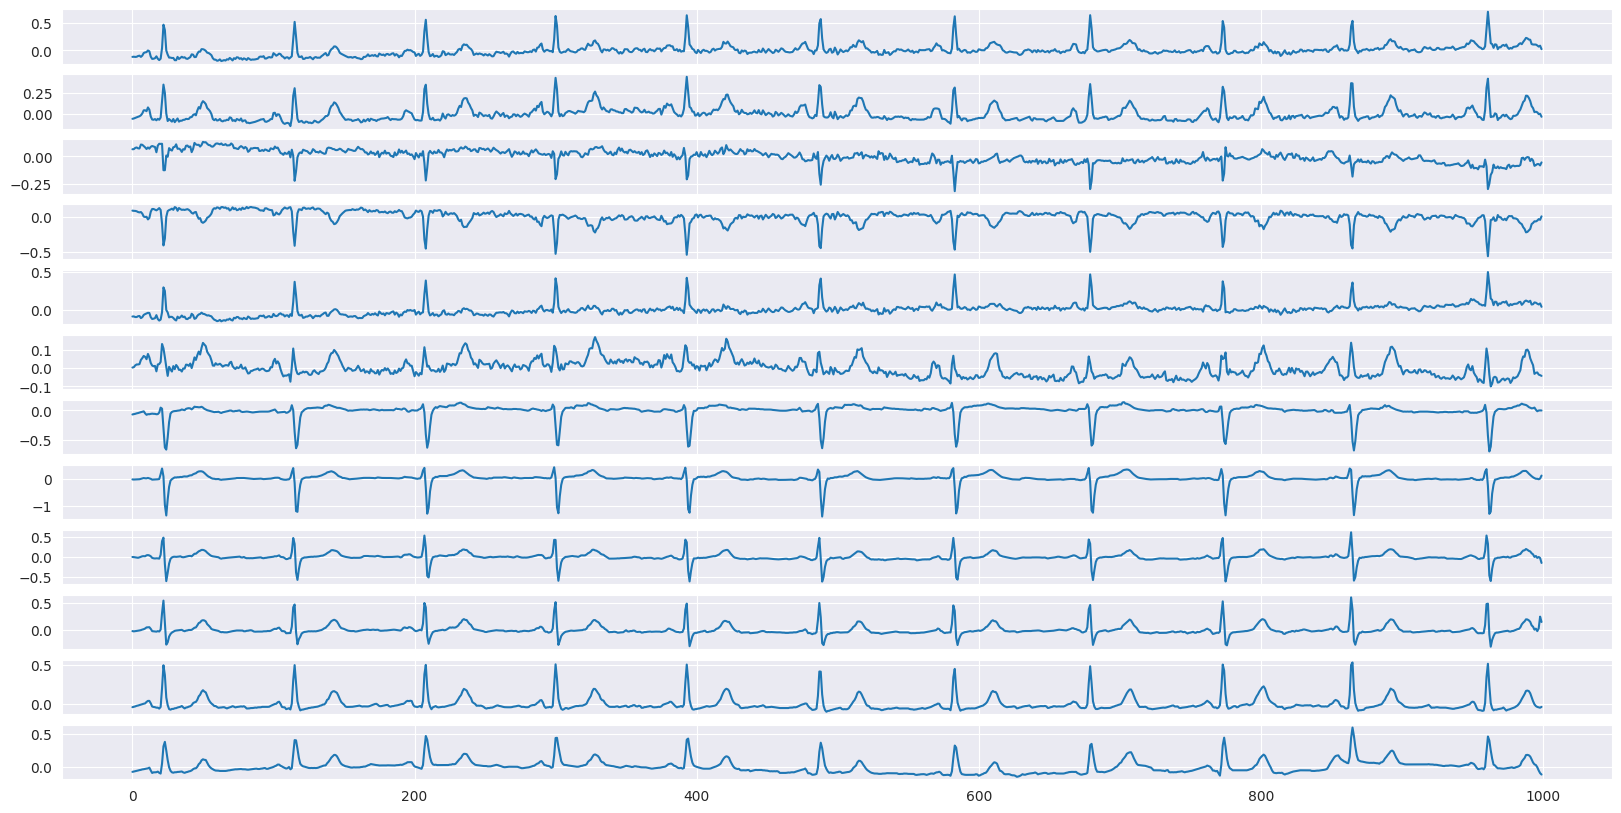

In [ ]:
sample = ECG_data[0]
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20,10))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
# plt.tight_layout()
plt.show()

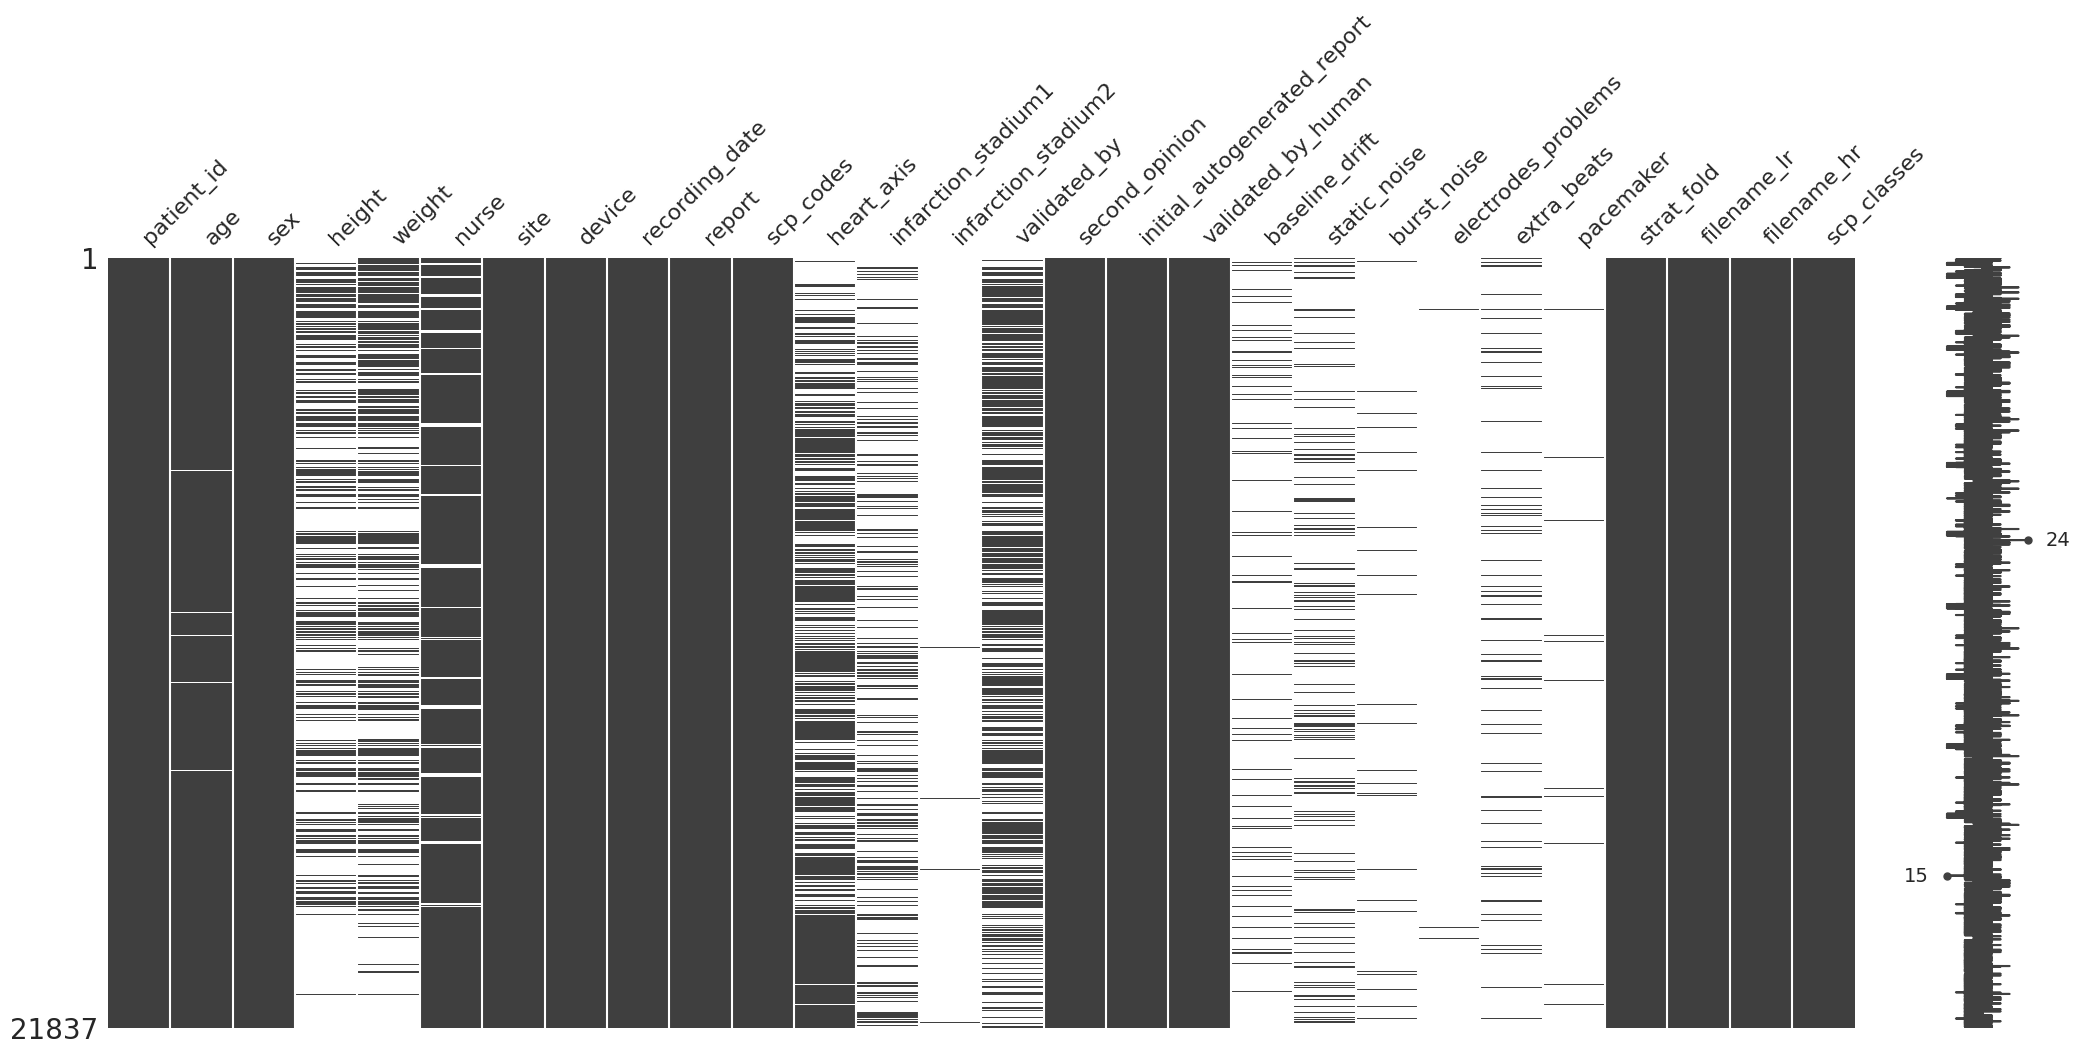

In [ ]:
import missingno as msno

msno.matrix(ECG_df)
plt.show()

In [ ]:
ECG_df[[col for col in ECG_df.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

patient_id                      18885
age                                94
sex                                 2
height                             77
weight                            127
nurse                              12
site                               51
device                             11
recording_date                  21813
report                           9883
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    321
static_noise                      124
burst_noise                       103
electrodes_problems                14
extra_beats                       128
pacemaker                           4
strat_fold                         10
filename_lr                     21837
filename_hr                     21837
dtype: int64

Далее задаем целевые переменные

Создаем дополниетльные признаки


In [ ]:
X = pd.DataFrame(index=ECG_df.index)

X['age'] = ECG_df.age
X.age.fillna(0, inplace=True)

X['sex'] = ECG_df.sex.astype(float)
X.sex.fillna(0, inplace=True)

X['height'] = ECG_df.height
X.loc[X.height < 50, 'height'] = np.nan
X.height.fillna(0, inplace=True)

X['weight'] = ECG_df.weight
X.weight.fillna(0, inplace=True)

X['infarction_stadium1'] = ECG_df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ECG_df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

X

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,pacemaker
ecg_id,,,,,,,
1,56.0,1.0,0.0,63.0,0.0,0.0,0.0
2,19.0,0.0,0.0,70.0,0.0,0.0,0.0
3,37.0,1.0,0.0,69.0,0.0,0.0,0.0
4,24.0,0.0,0.0,82.0,0.0,0.0,0.0
5,19.0,1.0,0.0,70.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
21833,67.0,1.0,0.0,0.0,0.0,0.0,0.0
21834,93.0,0.0,0.0,0.0,4.0,0.0,0.0
21835,59.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
Z = pd.DataFrame(0, index=ECG_df.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in ECG_df.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


In [ ]:
X_train, Y_train, Z_train = X[ECG_df.strat_fold <= 8],  ECG_data[X[ECG_df.strat_fold <= 8].index - 1],  Z[ECG_df.strat_fold <= 8]
X_valid, Y_valid, Z_valid = X[ECG_df.strat_fold == 9],  ECG_data[X[ECG_df.strat_fold == 9].index - 1],  Z[ECG_df.strat_fold == 9]
X_test,  Y_test,  Z_test  = X[ECG_df.strat_fold == 10], ECG_data[X[ECG_df.strat_fold == 10].index - 1], Z[ECG_df.strat_fold == 10]

print(X_train.shape, Y_train.shape, Z_train.shape)
print(X_valid.shape, Y_valid.shape, Z_valid.shape)
print(X_test.shape,  Y_test.shape,  Z_test.shape)

(17441, 7) (17441, 1000, 12) (17441, 5)
(2193, 7) (2193, 1000, 12) (2193, 5)
(2203, 7) (2203, 1000, 12) (2203, 5)


добавляем стандартизацию


In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaler.fit(X_train)

X_train = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(X_scaler.transform(X_valid), columns=X_valid.columns)
X_test  = pd.DataFrame(X_scaler.transform(X_test),  columns=X_test.columns)

In [ ]:
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

Y_train = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_valid = Y_scaler.transform(Y_valid.reshape(-1, Y_valid.shape[-1])).reshape(Y_valid.shape)
Y_test  = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

#Архитектура

Далее сама архитектура. Представлена сверточная нейронная сеть состоящая из двух сверточных слоев, с функцией ошибок бинарная кросс энтропия и оптимизатором адам

для набора данных с признаками слздается отдельная нейронная сеть

In [ ]:
import tensorflow as tf

def create_X_model(X, *, units=32, dropouts=0.3):
    X = tf.keras.layers.Dense(units, activation='relu', name='X_dense_1')(X)
    X = tf.keras.layers.Dropout(dropouts, name='X_drop_1')(X)
    X = tf.keras.layers.Dense(units, activation='relu', name='X_dense_2')(X)
    X = tf.keras.layers.Dropout(dropouts, name='X_drop_2')(X)
    return X

нейронная сеть использующая только данные признаков без ЭКГ

In [ ]:
def create_model01(X_shape, Z_shape):
    X_inputs = keras.Input(X_shape[1:], name='X_inputs')

    X = create_X_model(X_inputs)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=X_inputs, outputs=outputs, name='model01')
    return model

In [ ]:
model01 = create_model01(X_train.shape, Z_train.shape)
model01.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model01.summary()

Model: "model01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 X_inputs (InputLayer)       [(None, 7)]               0         
                                                                 
 X_dense_1 (Dense)           (None, 32)                256       
                                                                 
 X_drop_1 (Dropout)          (None, 32)                0         
                                                                 
 X_dense_2 (Dense)           (None, 32)                1056      
                                                                 
 X_drop_2 (Dropout)          (None, 32)                0         
                                                                 
 Z_dense_1 (Dense)           (None, 64)                2112      
                                                                 
 Z_dense_2 (Dense)           (None, 64)                4160

нейронная сеть для данных ЭКГ

# 2 слоя

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


example_ecg_data = tf.random.normal(shape=(1000,))


def create_Y_model(input_shape=(1000, 1), filters=(32, 64)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters[0], kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[1], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model




дополнительный слой в которм конкатенируются обе модели

In [ ]:
def create_model02(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(shape=X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(shape=Y_shape[1:], name='Y_inputs')

    Y_output = create_Y_model(input_shape=Y_shape[1:], filters=(64, 128))(Y_inputs)

    X = create_X_model(X_inputs)

    X = keras.layers.Concatenate(name='Z_concat')([X, Y_output])

    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='model02')
    return model

In [ ]:
model02 = create_model02(X_train.shape, Y_train.shape, Z_train.shape)
model02.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model02.summary()


In [ ]:

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)
]
history = model02.fit([X_train, Y_train], Z_train, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid))



# 2 слоя tanh


In [ ]:
from keras import activations

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


example_ecg_data = tf.random.normal(shape=(1000,))


def create_Y_modeltanh(input_shape=(1000, 1), filters=(32, 64)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters[0], kernel_size=5, activation=activations.tanh, input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[1], kernel_size=5, activation=activations.tanh))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation=activations.tanh))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
def create_model02tanh(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(shape=X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(shape=Y_shape[1:], name='Y_inputs')

    Y_output = create_Y_modeltanh(input_shape=Y_shape[1:], filters=(64, 128))(Y_inputs)

    X = create_X_model(X_inputs)

    X = keras.layers.Concatenate(name='Z_concat')([X, Y_output])

    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='model02')
    return model

In [ ]:
model02tanh = create_model02tanh(X_train.shape, Y_train.shape, Z_train.shape)
model02tanh.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model02tanh.summary()

In [ ]:

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)
]
history2tanh = model02tanh.fit([X_train, Y_train], Z_train, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid))



# 2 слоя maxpooling 10, 5


In [ ]:
def create_Y_model22(input_shape=(1000, 1), filters=(32, 64)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters[0], kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=10))
    model.add(tf.keras.layers.Conv1D(filters=filters[1], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
def create_model022(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(shape=X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(shape=Y_shape[1:], name='Y_inputs')

    Y_output = create_Y_model22(input_shape=Y_shape[1:], filters=(64, 128))(Y_inputs)

    X = create_X_model(X_inputs)

    X = keras.layers.Concatenate(name='Z_concat')([X, Y_output])

    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='model02')
    return model

In [ ]:
model022 = create_model022(X_train.shape, Y_train.shape, Z_train.shape)
model022.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model022.summary()

In [ ]:

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)
]
history3 = model03.fit([X_train, Y_train], Z_train, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid))



# 3 слоя


In [ ]:
def create_Y_model3(input_shape=(1000, 1), filters=(32, 64, 128)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters[0], kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[1], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[2], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
def create_model03(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(shape=X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(shape=Y_shape[1:], name='Y_inputs')

    Y_output = create_Y_model3(input_shape=Y_shape[1:], filters=(64, 128, 256))(Y_inputs)

    X = create_X_model(X_inputs)

    X = keras.layers.Concatenate(name='Z_concat')([X, Y_output])

    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='model02')
    return model

In [ ]:
model03 = create_model03(X_train.shape, Y_train.shape, Z_train.shape)
model03.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model03.summary()

In [ ]:

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)
]
history3 = model03.fit([X_train, Y_train], Z_train, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid))



# 4 слоя


In [ ]:
def create_Y_model4(input_shape=(1000, 1), filters=(32, 64, 128, 256)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters[0], kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[1], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[2], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[3], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
def create_model04(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(shape=X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(shape=Y_shape[1:], name='Y_inputs')

    Y_output = create_Y_model4(input_shape=Y_shape[1:], filters=(64, 128, 256, 528))(Y_inputs)

    X = create_X_model(X_inputs)

    X = keras.layers.Concatenate(name='Z_concat')([X, Y_output])

    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='model04')
    return model

In [ ]:
model04 = create_model04(X_train.shape, Y_train.shape, Z_train.shape)
model04.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model04.summary()

In [ ]:

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)
]
history10 = model010.fit([X_train, Y_train], Z_train, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid))



# 5 слоев relu

In [ ]:
from keras import activations

In [ ]:
def create_Y_model5(input_shape=(1000, 1), filters=(32, 64, 128, 256, 528)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters[0], kernel_size=5, activation=activations.relu, input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[1], kernel_size=5, activation=activations.relu))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[2], kernel_size=5, activation=activations.relu))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[3], kernel_size=5, activation=activations.relu))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[4], kernel_size=5, activation=activations.relu))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation=activations.relu))
    model.add(tf.keras.layers.Dense(64))
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras import activations, layers, models, Input

In [ ]:
def create_model05(Y_shape, Z_shape):
    Y_inputs = keras.Input(shape=Y_shape[1:], name='Y_inputs')

    Y_output = create_Y_model5(input_shape=Y_shape[1:], filters=(32, 64, 128, 256, 528))(Y_inputs)
    Y_output = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(Y_output)
    Y_output = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(Y_output)
    Y_output = keras.layers.Dropout(0.5, name='Z_drop_1')(Y_output)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(Y_output)

    model = keras.Model(inputs= Y_inputs, outputs=outputs, name='model05')
    return model

In [ ]:
model05 = create_model05(Y_train.shape, Z_train.shape)
model05.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model05.summary()

Model: "model05"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Y_inputs (InputLayer)       [(None, 1000, 12)]        0         
                                                                 
 sequential (Sequential)     (None, 64)                4551728   
                                                                 
 Z_dense_1 (Dense)           (None, 64)                4160      
                                                                 
 Z_dense_2 (Dense)           (None, 64)                4160      
                                                                 
 Z_drop_1 (Dropout)          (None, 64)                0         
                                                                 
 Z_outputs (Dense)           (None, 5)                 325       
                                                                 
Total params: 4560373 (17.40 MB)
Trainable params: 4560373 

In [ ]:
tf.keras.utils.plot_model(model05,show_shapes=True,
    show_dtype=True,
    show_layer_names=True)

In [ ]:

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)
]
history5 = model05.fit(Y_train, Z_train, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=( Y_valid, Z_valid))



Epoch 1/10
546/546 [==============================] - 23s 23ms/step - loss: 0.4347 - binary_accuracy: 0.8057 - precision: 0.6864 - recall: 0.4375 - val_loss: 0.3873 - val_binary_accuracy: 0.8432 - val_precision: 0.7448 - val_recall: 0.5883
Epoch 2/10
546/546 [==============================] - 11s 20ms/step - loss: 0.3497 - binary_accuracy: 0.8565 - precision: 0.7638 - recall: 0.6322 - val_loss: 0.3243 - val_binary_accuracy: 0.8610 - val_precision: 0.7672 - val_recall: 0.6550
Epoch 3/10
546/546 [==============================] - 8s 14ms/step - loss: 0.3179 - binary_accuracy: 0.8709 - precision: 0.7869 - recall: 0.6769 - val_loss: 0.3521 - val_binary_accuracy: 0.8613 - val_precision: 0.7714 - val_recall: 0.6500
Epoch 4/10
546/546 [==============================] - 7s 12ms/step - loss: 0.3000 - binary_accuracy: 0.8799 - precision: 0.8037 - recall: 0.6995 - val_loss: 0.3214 - val_binary_accuracy: 0.8673 - val_precision: 0.7543 - val_recall: 0.7132
Epoch 5/10
546/546 [======================

# 5 слоев relu avgpooling

In [ ]:
from keras import activations

In [ ]:
def create_Y_model5t(input_shape=(1000, 1), filters=(32, 64, 128, 256, 528)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters[0], kernel_size=5, activation=activations.tanh, input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[1], kernel_size=5, activation=activations.tanh))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[2], kernel_size=5, activation=activations.tanh))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[3], kernel_size=5, activation=activations.tanh))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[4], kernel_size=5, activation=activations.tanh))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation=activations.tanh))
    model.add(tf.keras.layers.Dense(64))
    return model

In [ ]:
def create_model05t(Y_shape, Z_shape):
    Y_inputs = keras.Input(shape=Y_shape[1:], name='Y_inputs')

    Y_output = create_Y_model5(input_shape=Y_shape[1:], filters=(32, 64, 128, 256, 528))(Y_inputs)
    Y_output = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(Y_output)
    Y_output = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(Y_output)
    Y_output = keras.layers.Dropout(0.5, name='Z_drop_1')(Y_output)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(Y_output)

    model = keras.Model(inputs= Y_inputs, outputs=outputs, name='model05')
    return model

In [ ]:
model05t = create_model05t(Y_train.shape, Z_train.shape)
model05t.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model05t.summary()

In [ ]:

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)
]
history5t = model05t.fit(Y_train, Z_train, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=(Y_valid, Z_valid))



Epoch 1/10
546/546 [==============================] - 12s 15ms/step - loss: 0.4255 - binary_accuracy: 0.8133 - precision: 0.6994 - recall: 0.4686 - val_loss: 0.3572 - val_binary_accuracy: 0.8544 - val_precision: 0.7492 - val_recall: 0.6468
Epoch 2/10
546/546 [==============================] - 7s 13ms/step - loss: 0.3475 - binary_accuracy: 0.8586 - precision: 0.7633 - recall: 0.6453 - val_loss: 0.3332 - val_binary_accuracy: 0.8590 - val_precision: 0.7800 - val_recall: 0.6247
Epoch 3/10
546/546 [==============================] - 8s 14ms/step - loss: 0.3208 - binary_accuracy: 0.8709 - precision: 0.7869 - recall: 0.6767 - val_loss: 0.3195 - val_binary_accuracy: 0.8669 - val_precision: 0.7831 - val_recall: 0.6632
Epoch 4/10
546/546 [==============================] - 7s 12ms/step - loss: 0.2987 - binary_accuracy: 0.8823 - precision: 0.8065 - recall: 0.7079 - val_loss: 0.3163 - val_binary_accuracy: 0.8715 - val_precision: 0.7951 - val_recall: 0.6700
Epoch 5/10
546/546 [=======================

# 5 слоев tanh

In [ ]:
from keras import activations

In [ ]:
def create_Y_model5(input_shape=(1000, 1), filters=(32, 64, 128, 256, 528)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters[0], kernel_size=5, activation=activations.tanh, input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[1], kernel_size=5, activation=activations.tanh))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[2], kernel_size=5, activation=activations.tanh))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[3], kernel_size=5, activation=activations.tanh))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[4], kernel_size=5, activation=activations.tanh))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation=activations.tanh))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
def create_model05(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(shape=X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(shape=Y_shape[1:], name='Y_inputs')

    Y_output = create_Y_model5(input_shape=Y_shape[1:], filters=(32, 64, 128, 256, 528))(Y_inputs)

    X = create_X_model(X_inputs)

    X = keras.layers.Concatenate(name='Z_concat')([X, Y_output])

    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='model05')
    return model

In [ ]:
model05 = create_model05(X_train.shape, Y_train.shape, Z_train.shape)
model05.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model05.summary()

In [ ]:

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)
]
history5 = model05.fit([X_train, Y_train], Z_train, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid))



# 6 слоев


In [ ]:
def create_Y_model6(input_shape=(1000, 1), filters=(32, 64, 128, 128, 256, 528)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters[0], kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[1], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[2], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[3], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[4], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[5], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
def create_model06(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(shape=X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(shape=Y_shape[1:], name='Y_inputs')

    Y_output = create_Y_model6(input_shape=Y_shape[1:], filters=(32, 64, 128, 128, 256, 528))(Y_inputs)

    X = create_X_model(X_inputs)

    X = keras.layers.Concatenate(name='Z_concat')([X, Y_output])

    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='model06')
    return model

In [ ]:
model06 = create_model06(X_train.shape, Y_train.shape, Z_train.shape)
model06.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model06.summary()

In [ ]:

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)
]
history6 = model06.fit([X_train, Y_train], Z_train, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid))



#7 слоев


In [ ]:
def create_Y_model7(input_shape=(1000, 1), filters=(32, 64, 128, 128, 256, 528)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters[0], kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[1], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[2], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[3], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[4], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[5], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[6], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
def create_model07(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(shape=X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(shape=Y_shape[1:], name='Y_inputs')

    Y_output = create_Y_model7(input_shape=Y_shape[1:], filters=(32, 64, 128, 128,128, 128, 128,128, 256, 528))(Y_inputs)

    X = create_X_model(X_inputs)

    X = keras.layers.Concatenate(name='Z_concat')([X, Y_output])

    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='model06')
    return model

In [ ]:
model07 = create_model07(X_train.shape, Y_train.shape, Z_train.shape)
model07.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model07.summary()

In [ ]:

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)
]
history10 = model010.fit([X_train, Y_train], Z_train, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid))



In [ ]:
from keras import activations

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


example_ecg_data = tf.random.normal(shape=(1000,))


def create_Y_modeltanh(input_shape=(1000, 1), filters=(32, 64)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters[0], kernel_size=5, activation=activations.tanh, input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[1], kernel_size=5, activation=activations.tanh))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation=activations.tanh))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
def create_model02tanh(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(shape=X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(shape=Y_shape[1:], name='Y_inputs')

    Y_output = create_Y_modeltanh(input_shape=Y_shape[1:], filters=(64, 128))(Y_inputs)

    X = create_X_model(X_inputs)

    X = keras.layers.Concatenate(name='Z_concat')([X, Y_output])

    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='model02')
    return model

In [ ]:
model02tanh = create_model02tanh(X_train.shape, Y_train.shape, Z_train.shape)
model02tanh.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model02tanh.summary()

In [ ]:

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)
]
history2tanh = model02tanh.fit([X_train, Y_train], Z_train, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid))



#Результаты

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['recall'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 3

In [ ]:
labels=['NORM', 'MI', 'STTC', 'CD', 'HYP']
Z_pred_03 = model03.predict([X_test, Y_test]).round().astype(int)

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Class - " + class_label)

fig, ax = plt.subplots(1, 5, figsize=(16, 3))

for axes, cfs_matrix, label in zip(ax.flatten(), metrics.multilabel_confusion_matrix(Z_test, Z_pred_03), labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

print(metrics.classification_report(Z_test, Z_pred_03, target_names=labels, zero_division=0))

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['recall'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2

In [ ]:
labels=['NORM', 'MI', 'STTC', 'CD', 'HYP']
Z_pred_02 = model02.predict([X_test, Y_test]).round().astype(int)

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Class - " + class_label)

fig, ax = plt.subplots(1, 5, figsize=(16, 3))

for axes, cfs_matrix, label in zip(ax.flatten(), metrics.multilabel_confusion_matrix(Z_test, Z_pred_02), labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

print(metrics.classification_report(Z_test, Z_pred_02, target_names=labels, zero_division=0))

In [ ]:
labels=['NORM', 'MI', 'STTC', 'CD', 'HYP']
Z_pred_02tanh = model02tanh.predict([X_test, Y_test]).round().astype(int)

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Class - " + class_label)

fig, ax = plt.subplots(1, 5, figsize=(16, 3))

for axes, cfs_matrix, label in zip(ax.flatten(), metrics.multilabel_confusion_matrix(Z_test, Z_pred_02tanh), labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

print(metrics.classification_report(Z_test, Z_pred_02tanh, target_names=labels, zero_division=0))

# 4

In [ ]:
labels=['NORM', 'MI', 'STTC', 'CD', 'HYP']
Z_pred_04 = model04.predict([X_test, Y_test]).round().astype(int)

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Class - " + class_label)

fig, ax = plt.subplots(1, 5, figsize=(16, 3))

for axes, cfs_matrix, label in zip(ax.flatten(), metrics.multilabel_confusion_matrix(Z_test, Z_pred_04), labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

print(metrics.classification_report(Z_test, Z_pred_04, target_names=labels, zero_division=0))

#5

In [ ]:
labels=['NORM', 'MI', 'STTC', 'CD', 'HYP']
Z_pred_05 = model05.predict(Y_test).round().astype(int)

69/69 [==============================] - 3s 33ms/step


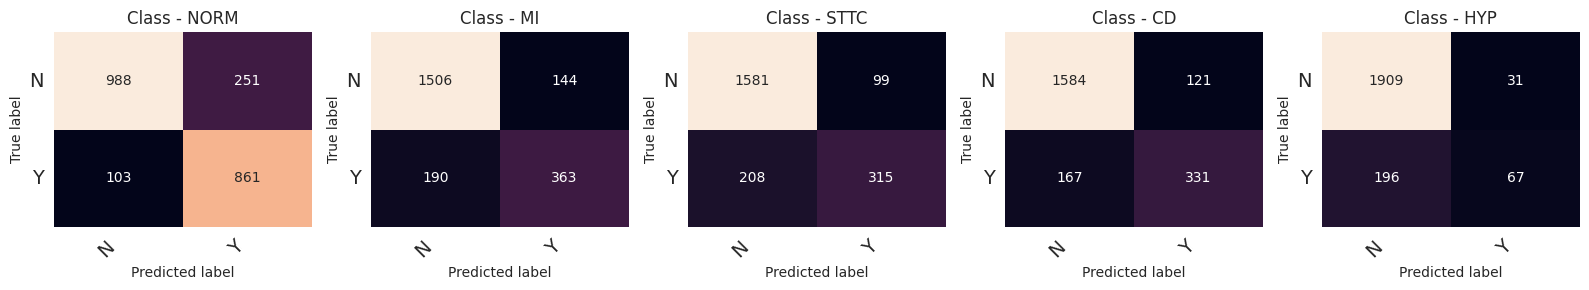

              precision    recall  f1-score   support

        NORM       0.77      0.89      0.83       964
          MI       0.72      0.66      0.68       553
        STTC       0.76      0.60      0.67       523
          CD       0.73      0.66      0.70       498
         HYP       0.68      0.25      0.37       263

   micro avg       0.75      0.69      0.72      2801
   macro avg       0.73      0.61      0.65      2801
weighted avg       0.74      0.69      0.70      2801
 samples avg       0.74      0.71      0.71      2801

0.5801180208806174


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Class - " + class_label)

fig, ax = plt.subplots(1, 5, figsize=(16, 3))

for axes, cfs_matrix, label in zip(ax.flatten(), metrics.multilabel_confusion_matrix(Z_test, Z_pred_05), labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

print(metrics.classification_report(Z_test, Z_pred_05, target_names=labels, zero_division=0))
print(metrics.accuracy_score(Z_pred_05, Z_test))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
conf_matrix = metrics.multilabel_confusion_matrix(Z_test, Z_pred_05)

# Нормализуем матрицу по строкам (истинные метки)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Умножаем на 100 для получения процентов
conf_matrix_percentage = conf_matrix_normalized * 100

print("Confusion Matrix (in percentages):")
print(conf_matrix_percentage)

Confusion Matrix (in percentages):
[[[90.55912007 22.57194245]
  [ 9.44087993 77.42805755]]

 [[88.79716981 28.40236686]
  [11.20283019 71.59763314]]

 [[88.37339296 23.91304348]
  [11.62660704 76.08695652]]

 [[90.4625928  26.7699115 ]
  [ 9.5374072  73.2300885 ]]

 [[90.6888361  31.63265306]
  [ 9.3111639  68.36734694]]]


In [ ]:
conf_matrix = metrics.multilabel_confusion_matrix(Z_test, Z_pred_06)

# Нормализуем матрицу по строкам (истинные метки)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Умножаем на 100 для получения процентов
conf_matrix_percentage = conf_matrix_normalized * 100

print("Confusion Matrix (in percentages):")
print(conf_matrix_percentage)

Confusion Matrix (in percentages):
[[[89.13987837 20.24714829]
  [10.86012163 79.75285171]]

 [[87.42791234 28.57142857]
  [12.57208766 71.42857143]]

 [[89.55916473 28.39248434]
  [10.44083527 71.60751566]]

 [[90.58891455 28.87473461]
  [ 9.41108545 71.12526539]]

 [[91.87192118 43.35260116]
  [ 8.12807882 56.64739884]]]


#6

In [ ]:
labels=['NORM', 'MI', 'STTC', 'CD', 'HYP']
Z_pred_06 = model05t.predict(Y_test).round().astype(int)

69/69 [==============================] - 0s 4ms/step


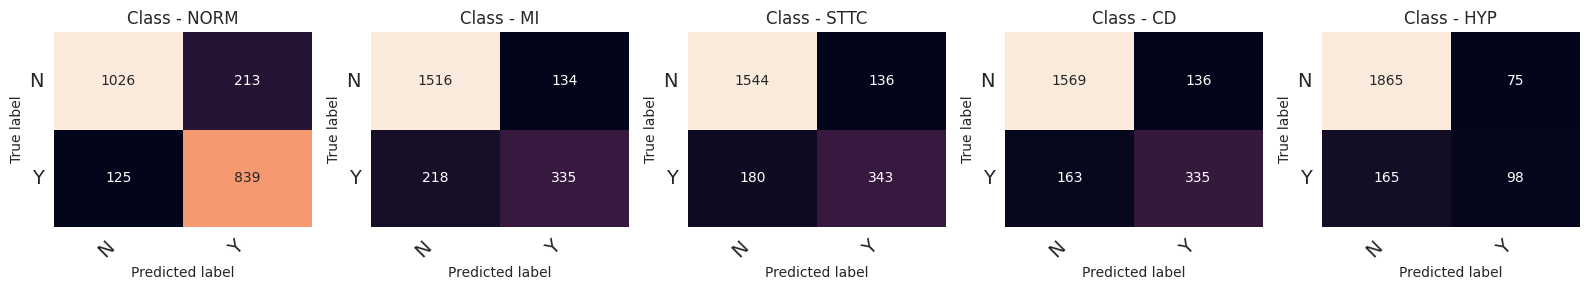

              precision    recall  f1-score   support

        NORM       0.80      0.87      0.83       964
          MI       0.71      0.61      0.66       553
        STTC       0.72      0.66      0.68       523
          CD       0.71      0.67      0.69       498
         HYP       0.57      0.37      0.45       263

   micro avg       0.74      0.70      0.72      2801
   macro avg       0.70      0.64      0.66      2801
weighted avg       0.73      0.70      0.71      2801
 samples avg       0.74      0.71      0.71      2801



In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Class - " + class_label)

fig, ax = plt.subplots(1, 5, figsize=(16, 3))

for axes, cfs_matrix, label in zip(ax.flatten(), metrics.multilabel_confusion_matrix(Z_test, Z_pred_06), labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

print(metrics.classification_report(Z_test, Z_pred_06, target_names=labels, zero_division=0))